In [1]:
import numpy as np
from typing import List
import os
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
# from lib_FrogsCNN import *
torch.backends.cudnn.enabled = False

split_seed = 123

c:\Users\tgh11\anaconda3\envs\ds\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomTensorDataset(torch.utils.data.TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
def dataloader_Frogs(batch_size_train = 16, batch_size_test = 2, random_seed=112892):
    torch.manual_seed(random_seed)
    train_dataset = torchvision.datasets.ImageFolder("./filled_images/")
    transform_image = torchvision.transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([512, 512]),
        # transforms.RandomRotation(degrees=90),
        # transforms.RandomVerticalFlip(p=0.5),
        # transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])
    
    vec_id = ["Clade4","Clade5","Clade8","Clade12"]
    vec_id_value = []
    for ii in vec_id:
        vec_id_value.append(train_dataset.class_to_idx[ii])
    vec_ood_value = set(train_dataset.class_to_idx.values()).difference(vec_id_value)
    dic_total = {train_dataset.class_to_idx[vec_id[i]]:i for i in range(4)}
    s = pd.Series(data=dic_total.values(), index=dic_total.keys())

    mat_dataset = np.empty(shape=(0,3,512,512))
    vec_labels=np.empty(shape=0)
    for _,data in enumerate(train_dataset):
        mat_dataset = np.vstack((mat_dataset,transform_image(data[0]).reshape(1,3,512,512)))
        vec_labels = np.append(vec_labels,data[1])
    vec_ood_idx = []
    vec_id_idx = []
    for ii in range(len(vec_labels)):
        if vec_labels[ii] in vec_ood_value:
            vec_ood_idx.append(ii)
        else:
            vec_id_idx.append(ii)
    mat_dataset_id = mat_dataset[vec_id_idx,:]
    mat_dataset_ood = mat_dataset[vec_ood_idx,:]
    vec_labels_id = vec_labels[vec_id_idx]
    vec_labels_id_coded = np.array(s[vec_labels_id])
    vec_labels_ood = vec_labels[vec_ood_idx]

    X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(mat_dataset_id, vec_labels_id_coded,
                                   random_state=split_seed, 
                                   test_size=0.10, 
                                   shuffle=True)

    X_train_ood, X_test_ood, y_train_ood, y_test_ood = train_test_split(mat_dataset_ood, vec_labels_ood,
                                    random_state=split_seed, 
                                    test_size=0.10, 
                                    shuffle=True)

    transform_image_v2 = torchvision.transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([512, 512]),
        # transforms.RandomRotation(degrees=90),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])

    train_dataset_id = CustomTensorDataset((torch.Tensor(X_train_id), torch.Tensor(y_train_id))
        , transform=transform_image_v2)
    train_dataset_ood = CustomTensorDataset((torch.Tensor(X_train_ood), torch.Tensor(y_train_ood))
        , transform=transform_image_v2)

    test_dataset_id = CustomTensorDataset((torch.Tensor(X_test_id), torch.Tensor(y_test_id))
        , transform=transform_image_v2)
    test_dataset_ood = CustomTensorDataset((torch.Tensor(X_test_ood), torch.Tensor(y_test_ood))
        , transform=transform_image_v2)


    train_loader_id = torch.utils.data.DataLoader(train_dataset_id,
        batch_size=batch_size_train, shuffle=True)
    train_loader_ood = torch.utils.data.DataLoader(train_dataset_ood,
        batch_size=batch_size_train, shuffle=True)

    test_loader_id = torch.utils.data.DataLoader(test_dataset_id,
        batch_size=batch_size_test, shuffle=True)
    test_loader_ood = torch.utils.data.DataLoader(test_dataset_ood,
        batch_size=batch_size_test, shuffle=True)
    
    print("train_loader_id, train_loader_ood")
    return train_loader_id, train_loader_ood, test_loader_id, test_loader_ood,train_dataset.class_to_idx,s

In [3]:
train_loader_id, train_loader_ood, test_loader_id, test_loader_ood, class_to_idx, df_coding = dataloader_Frogs()

train_loader_id, train_loader_ood


In [4]:
class_to_idx

{'Clade10': 0,
 'Clade11': 1,
 'Clade12': 2,
 'Clade16': 3,
 'Clade18': 4,
 'Clade20': 5,
 'Clade21': 6,
 'Clade4': 7,
 'Clade5': 8,
 'Clade8': 9}

In [5]:
df_coding

7    0
8    1
9    2
2    3
dtype: int64

In [6]:
train_loader_id.dataset.tensors[0].shape,test_loader_id.dataset.tensors[0].shape,\
train_loader_ood.dataset.tensors[0].shape,test_loader_ood.dataset.tensors[0].shape

(torch.Size([210, 3, 512, 512]),
 torch.Size([24, 3, 512, 512]),
 torch.Size([170, 3, 512, 512]),
 torch.Size([19, 3, 512, 512]))

In [7]:
# %load model.py
## define model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 4, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(4)

        self.fc1 = nn.Linear(15376, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv1_bn(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv2_bn(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv3_bn(x)


        x = x.view(-1, 15376)
        x = (self.fc1(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc1_bn(x)

        x = (self.fc2(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc2_bn(x)

        x = (self.fc3(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc3_bn(x)

        x = (self.fc4(x))
        return x
    
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader_id):
        optimizer.zero_grad()
        data = data.view(data.shape[0],-1,512,512)
        data = data.cuda()
        # target = target.argmax(axis = 1).view(-1,1)
        target = target.cuda()
        output = network(data)
        loss = F.cross_entropy((output), target.long())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_id.dataset),
                100. * batch_idx / len(train_loader_id), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*16) + ((epoch-1)*len(train_loader_id.dataset)))
        data.cpu()
        target.cpu()

network = Net()

In [8]:
learning_rate = 0.003
log_interval = 10
n_epochs = 2000
optimizer = optim.Adam(network.parameters(), lr=learning_rate)#,
                    #   momentum=momentum)
network.cuda()
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_id.dataset) for i in range(n_epochs + 1)]

network.cuda()
for epoch in range(1, n_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/210 (0%)]	Loss: 1.526270
Train Epoch: 1 [160/210 (71%)]	Loss: 1.488127
Train Epoch: 2 [0/210 (0%)]	Loss: 1.280096
Train Epoch: 2 [160/210 (71%)]	Loss: 1.528058
Train Epoch: 3 [0/210 (0%)]	Loss: 1.501290
Train Epoch: 3 [160/210 (71%)]	Loss: 1.448959
Train Epoch: 4 [0/210 (0%)]	Loss: 1.222905
Train Epoch: 4 [160/210 (71%)]	Loss: 1.424703
Train Epoch: 5 [0/210 (0%)]	Loss: 1.536315
Train Epoch: 5 [160/210 (71%)]	Loss: 1.310714
Train Epoch: 6 [0/210 (0%)]	Loss: 1.358530
Train Epoch: 6 [160/210 (71%)]	Loss: 1.416783
Train Epoch: 7 [0/210 (0%)]	Loss: 1.242974
Train Epoch: 7 [160/210 (71%)]	Loss: 1.253741
Train Epoch: 8 [0/210 (0%)]	Loss: 1.184720
Train Epoch: 8 [160/210 (71%)]	Loss: 1.409584
Train Epoch: 9 [0/210 (0%)]	Loss: 1.078401
Train Epoch: 9 [160/210 (71%)]	Loss: 1.201880
Train Epoch: 10 [0/210 (0%)]	Loss: 1.280645
Train Epoch: 10 [160/210 (71%)]	Loss: 1.218230
Train Epoch: 11 [0/210 (0%)]	Loss: 1.247029
Train Epoch: 11 [160/210 (71%)]	Loss: 1.393423
Train Epoch: 12 [

In [41]:
##save the module
torch.save(network.state_dict(), "seed_filled"+str(split_seed)+".pth")

In [10]:
# n_epochs = 500
# learning_rate = 0.001
# network.cuda()
# for epoch in range(1, n_epochs + 1):
#     train(epoch)

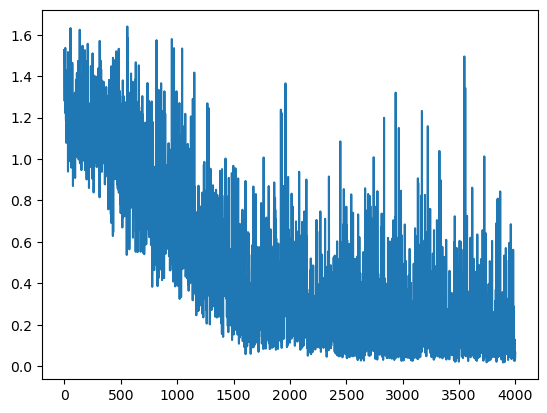

In [11]:
plt.plot(train_losses)

In [12]:
##load the model
# network.load_state_dict(torch.load("seed_111.pth"))

In [13]:
pre_label = np.empty(0)
true_label = np.empty(0)
network.cpu()
network.eval()
for batch_idx, (data, target) in enumerate(train_loader_id):
    true_label = np.append(true_label, target)
    out = network(data)
    pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
from sklearn.metrics import confusion_matrix
confusion_matrix(true_label, pre_label)

array([[ 40,   0,   0,   0],
       [  0,  18,   0,   0],
       [  0,   0, 104,   0],
       [  0,   0,   0,  48]], dtype=int64)

In [14]:
pre_label = np.empty(0)
true_label = np.empty(0)
network.cpu()
network.eval()
for batch_idx, (data, target) in enumerate(test_loader_id):
    true_label = np.append(true_label, target)
    out = network(data)
    pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
from sklearn.metrics import confusion_matrix
confusion_matrix(true_label, pre_label)

array([[4, 0, 2, 0],
       [1, 1, 2, 0],
       [2, 0, 8, 0],
       [0, 0, 3, 1]], dtype=int64)

In [15]:
## get intermediate output
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

hookF = [Hook(layer[1]) for layer in list(network._modules.items())]

In [16]:
batch_idx, (data, target) = next(enumerate(train_loader_id))
out=network(data)

print('***'*3+'  Forward Hooks Inputs & Outputs  '+'***'*3)
ll=0
for hook in hookF[:6]:
    print(ll)
    ll=ll+1
    print(hook.input[0].shape)
    print(hook.output.shape)
    print('---'*17)

*********  Forward Hooks Inputs & Outputs  *********
0
torch.Size([16, 3, 512, 512])
torch.Size([16, 32, 510, 510])
---------------------------------------------------
1
torch.Size([16, 32, 255, 255])
torch.Size([16, 32, 255, 255])
---------------------------------------------------
2
torch.Size([16, 32, 255, 255])
torch.Size([16, 16, 253, 253])
---------------------------------------------------
3
torch.Size([16, 16, 126, 126])
torch.Size([16, 16, 126, 126])
---------------------------------------------------
4
torch.Size([16, 16, 126, 126])
torch.Size([16, 4, 124, 124])
---------------------------------------------------
5
torch.Size([16, 4, 62, 62])
torch.Size([16, 4, 62, 62])
---------------------------------------------------


In [17]:
# ii = 1
# from matplotlib.transforms import Bbox
# import cv2
# my_dpi = 100 # Good default - doesn't really matter
# fig, ax = plt.subplots(1, figsize=(8,8))
# ax.set_position([0, 0, 1, 1]) # Critical!
# plt.imshow(np.moveaxis(np.array(hookF[0].input[0][ii,:,:,:]),0,2))
# ax.axis("off")
# # fig.savefig("LayerInput_"+str(ii)+".pdf",bbox_inches='tight')


# fig, axs = plt.subplots(4,4, figsize=(8,8))
# ll=0
# for i in range(4):
#     for j in range(4):
#         axs[i][j].imshow(hookF[4].input[0][ii,ll,:].detach().numpy(), "gray")
#         axs[i][j].axis("off")
#         axs[i][j].set_xticklabels([])
#         axs[i][j].set_yticklabels([])
#         axs[i][j].set_aspect('equal')
#         axs[i][j].set_position([0, 0, 1, 1])
#         ll=ll+1
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
# # plt.savefig("LayerConv3_"+str(ii)+".pdf",bbox_inches='tight')

# fig, axs = plt.subplots(1,4, figsize=[32,16])
# for i in range(4):
#     axs[i].imshow(hookF[5].input[0][ii,i,:].detach().numpy(),"gray")
#     axs[i].axis("off")
#     axs[i].set_xticklabels([])
#     axs[i].set_yticklabels([])
#     axs[i].set_aspect('equal')
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0)
# # plt.savefig("LayerConv4-a_"+str(ii)+".pdf",bbox_inches='tight')

In [18]:
# for batch_idx, (data, target) in (enumerate(train_loader_id)):
#     out=network(data)
#     print(hookF[0].input[0].shape[0])

In [19]:
# from matplotlib.transforms import Bbox
# import cv2
# pp = PdfPages("temp.pdf")
# for batch_idx, (data, target) in (enumerate(train_loader_id)):
#     out=network(data)
#     for ii in range(hookF[0].input[0].shape[0]):
#         fig, ax = plt.subplots(1, figsize=(8,8))
#         ax.set_position([0, 0, 1, 1]) # Critical!
#         plt.imshow(np.moveaxis(np.array(hookF[0].input[0][ii,:,:,:]),0,2))
#         ax.axis("off")
#         pp.savefig(fig)

#         fig, axs = plt.subplots(4,4, figsize=(8,8))
#         ll=0
#         for i in range(4):
#             for j in range(4):
#                 axs[i][j].imshow(hookF[4].input[0][ii,ll,:].detach().numpy(), "gray")
#                 axs[i][j].axis("off")
#                 axs[i][j].set_xticklabels([])
#                 axs[i][j].set_yticklabels([])
#                 axs[i][j].set_aspect('equal')
#                 axs[i][j].set_position([0, 0, 1, 1])
#                 ll=ll+1
#         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
#         pp.savefig(fig)

#         fig, axs = plt.subplots(1,4, figsize=[32,16])
#         for i in range(4):
#             axs[i].imshow(hookF[5].input[0][ii,i,:].detach().numpy(),"gray")
#             axs[i].axis("off")
#             axs[i].set_xticklabels([])
#             axs[i].set_yticklabels([])
#             axs[i].set_aspect('equal')
#         plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0)
#         pp.savefig(fig)
# pp.close()

In [20]:
train_id_lay128=np.array([]).reshape(0,128)
train_id_lay64=np.array([]).reshape(0,64)
train_id_lay4=np.array([]).reshape(0,4)
true_target = np.array([]).reshape(-1)
for batch_idx, (data, target) in enumerate(train_loader_id):
    out=network(data)
    train_id_lay128 = np.vstack([train_id_lay128,hookF[8].output.detach().numpy()])
    train_id_lay64 = np.vstack([train_id_lay64,hookF[10].output.detach().numpy()])
    train_id_lay4 = np.vstack([train_id_lay4,hookF[12].output.detach().numpy()])
    true_target = np.concatenate((true_target, target))

df_train_id_128 = pd.DataFrame(train_id_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_train_id_128['dsource'] = "train_id"
df_train_id_128['true_lab']=true_target

df_train_id_64 = pd.DataFrame(train_id_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_train_id_64['dsource'] = "train_id"
df_train_id_64['true_lab']=true_target

df_train_id_4 = pd.DataFrame(train_id_lay4, columns=["lay4_"+str(i) for i in range(4)])
df_train_id_4['dsource'] = "train_id"
df_train_id_4['true_lab']=true_target


train_ood_lay128=np.array([]).reshape(0,128)
train_ood_lay64=np.array([]).reshape(0,64)
train_ood_lay4=np.array([]).reshape(0,4)
for batch_idx, (data, target) in enumerate(train_loader_ood):
    out=network(data)
    train_ood_lay128 = np.vstack([train_ood_lay128,hookF[8].output.detach().numpy()])
    train_ood_lay64 = np.vstack([train_ood_lay64,hookF[10].output.detach().numpy()])
    train_ood_lay4 = np.vstack([train_ood_lay4,hookF[12].output.detach().numpy()])


df_train_ood_128 = pd.DataFrame(train_ood_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_train_ood_128['dsource'] = "train_ood"
df_train_ood_128['true_lab']=-1

df_train_ood_64 = pd.DataFrame(train_ood_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_train_ood_64['dsource'] = "train_ood"
df_train_ood_64['true_lab']=-1

df_train_ood_4 = pd.DataFrame(train_ood_lay4, columns=["lay4_"+str(i) for i in range(4)])
df_train_ood_4['dsource'] = "train_ood"
df_train_ood_4['true_lab']=-1

In [21]:
df_train_128_all = pd.concat((df_train_id_128, df_train_ood_128))
df_train_64_all = pd.concat((df_train_id_64, df_train_ood_64))
df_train_4_all = pd.concat((df_train_id_4, df_train_ood_4))

In [22]:
test_id_lay128=np.array([]).reshape(0,128)
test_id_lay64=np.array([]).reshape(0,64)
test_id_lay4=np.array([]).reshape(0,4)
true_target = np.array([]).reshape(-1)
for batch_idx, (data, target) in enumerate(test_loader_id):
    out=network(data)
    test_id_lay128 = np.vstack([test_id_lay128,hookF[8].output.detach().numpy()])
    test_id_lay64 = np.vstack([test_id_lay64,hookF[10].output.detach().numpy()])
    test_id_lay4 = np.vstack([test_id_lay4,hookF[12].output.detach().numpy()])
    true_target = np.concatenate((true_target, target))

df_test_id_128 = pd.DataFrame(test_id_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_test_id_128['dsource'] = "test_id"
df_test_id_128['true_lab']=true_target

df_test_id_64 = pd.DataFrame(test_id_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_test_id_64['dsource'] = "test_id"
df_test_id_64['true_lab']=true_target

df_test_id_4 = pd.DataFrame(test_id_lay4, columns=["lay4_"+str(i) for i in range(4)])
df_test_id_4['dsource'] = "test_id"
df_test_id_4['true_lab']=true_target


test_ood_lay128=np.array([]).reshape(0,128)
test_ood_lay64=np.array([]).reshape(0,64)
test_ood_lay4=np.array([]).reshape(0,4)
for batch_idx, (data, target) in enumerate(test_loader_ood):
    out=network(data)
    test_ood_lay128 = np.vstack([test_ood_lay128,hookF[8].output.detach().numpy()])
    test_ood_lay64 = np.vstack([test_ood_lay64,hookF[10].output.detach().numpy()])
    test_ood_lay4 = np.vstack([test_ood_lay4,hookF[12].output.detach().numpy()])


df_test_ood_128 = pd.DataFrame(test_ood_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_test_ood_128['dsource'] = "test_ood"
df_test_ood_128['true_lab']=-1

df_test_ood_64 = pd.DataFrame(test_ood_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_test_ood_64['dsource'] = "test_ood"
df_test_ood_64['true_lab']=-1

df_test_ood_4 = pd.DataFrame(test_ood_lay4, columns=["lay4_"+str(i) for i in range(4)])
df_test_ood_4['dsource'] = "test_ood"
df_test_ood_4['true_lab']=-1

In [23]:
df_test_128_all = pd.concat((df_test_id_128, df_test_ood_128))
df_test_64_all = pd.concat((df_test_id_64, df_test_ood_64))
df_test_4_all = pd.concat((df_test_id_4, df_test_ood_4))

In [24]:
##read the saved results
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
exec(open("./lib_RMD_v2.py").read())

# df_128_all = pd.read_csv("saved_res/layer_128_ferwer.csv", index_col=0)
# df_64_all= pd.read_csv("saved_res/layer_64_ferwer.csv", index_col=0)
# df_3_all= pd.read_csv("saved_res/layer_3_ferwer.csv", index_col=0)

In [25]:
from sklearn.linear_model import LogisticRegression
exec(open("./lib_RMD_v2.py").read())
df_train_QDA_robust, df_test_QDA_robust = df_mahdist_QDA(
    (df_train_128_all, df_train_64_all, df_train_4_all),
    (df_test_128_all, df_test_64_all, df_test_4_all),
    [128, 64, 4],4, Shrinkage = True)
df_train_LDA_robust, df_test_LDA_robust = df_mahdist_LDA(
    (df_train_128_all, df_train_64_all, df_train_4_all),
    (df_test_128_all, df_test_64_all, df_test_4_all),
    [128, 64, 4],4)


Text(0, 0.5, 'Count')

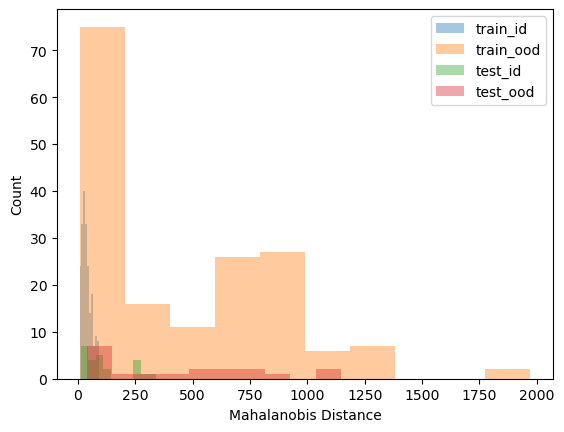

In [26]:
plt.figure
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_id"].dist_l128, alpha=.4, label='train_id')
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_ood"].dist_l128, alpha=.4, label='train_ood')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_id"].dist_l128, alpha=.4, label='test_id')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_ood"].dist_l128, alpha=.4, label='test_ood')
plt.legend()
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")
# plt.title("Distribution of Mahalanobis Distance for 128-unit Layer")
# plt.savefig('Frog_layer128_'+str(ii)+'.pdf')

Text(0, 0.5, 'Count')

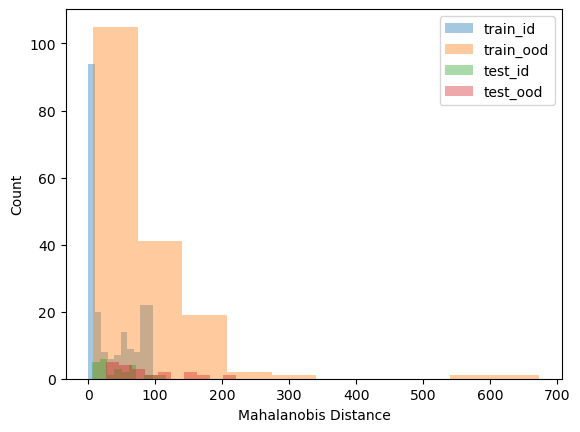

In [27]:
plt.figure
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_id"].dist_l64, alpha=.4, label='train_id')
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_ood"].dist_l64, alpha=.4, label='train_ood')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_id"].dist_l64, alpha=.4, label='test_id')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_ood"].dist_l64, alpha=.4, label='test_ood')
plt.legend()
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")
# plt.savefig('Frog_layer64_'+str(ii)+'.pdf')

Text(0, 0.5, 'Count')

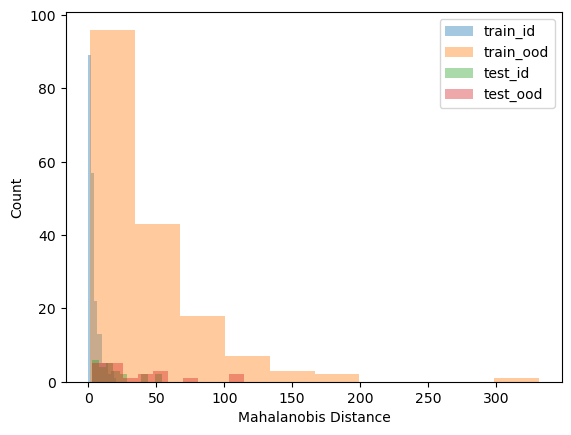

In [28]:
plt.figure
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_id"].dist_l4, alpha=.4, label='train_id')
plt.hist(df_train_QDA_robust[df_train_QDA_robust['dsource']=="train_ood"].dist_l4, alpha=.4, label='train_ood')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_id"].dist_l4, alpha=.4, label='test_id')
plt.hist(df_test_QDA_robust[df_test_QDA_robust['dsource']=="test_ood"].dist_l4, alpha=.4, label='test_ood')
plt.legend()
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")
# plt.savefig('Frog_layer3_'+str(ii)+'.pdf')

In [43]:
from sklearn.linear_model import LogisticRegression
df_train_QDA_robust['Y']=pd.Series([0 for x in range(len(df_train_QDA_robust.index))])
df_train_QDA_robust.loc[df_train_QDA_robust['dsource']=="train_ood",'Y'] = pd.Series([1 for x in range(np.sum(df_train_QDA_robust['dsource']=="train_ood"))])
df_test_QDA_robust['Y']=pd.Series([0 for x in range(len(df_test_QDA_robust.index))])
df_test_QDA_robust.loc[df_test_QDA_robust['dsource']=="test_ood",'Y'] = pd.Series([1 for x in range(np.sum(df_test_QDA_robust['dsource']=="test_ood"))])

clf = LogisticRegression(random_state=0).fit(
    df_train_QDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']],
    df_train_QDA_robust.loc[:,"Y"])

0.91296918767507


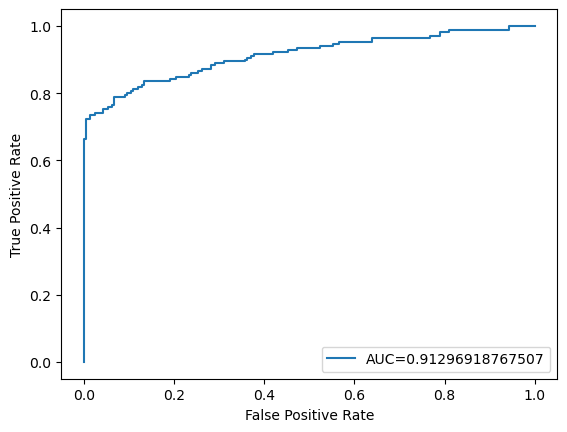

In [44]:
from sklearn import metrics

y_pred_proba = clf.predict_proba(df_train_QDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']])[::,1]
fpr, tpr, _ = metrics.roc_curve(df_train_QDA_robust.loc[:,'Y'],  y_pred_proba)

auc = metrics.roc_auc_score(df_train_QDA_robust.loc[:,'Y'], y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("QDA_ROC_filled.pdf")
plt.show()

0.75


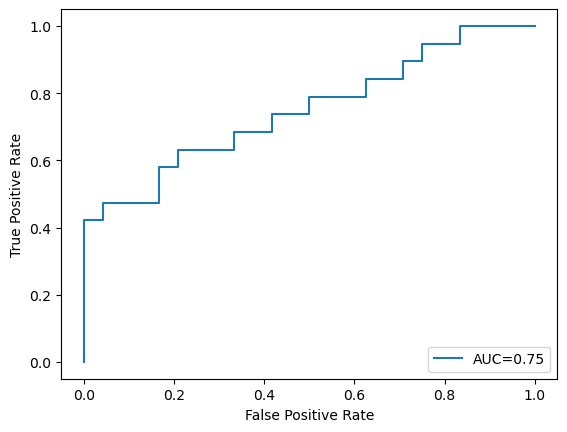

In [45]:
y_pred_proba = clf.predict_proba(df_test_QDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']])[::,1]
fpr, tpr, _ = metrics.roc_curve(df_test_QDA_robust.loc[:,'Y'],  y_pred_proba)

auc = metrics.roc_auc_score(df_test_QDA_robust.loc[:,'Y'], y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("QDA_ROC_prediction_filled.pdf")
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
vec_pre = clf.predict(df_train_QDA_robust.loc[df_train_QDA_robust['dsource'].isin(["train_id","train_ood"]),['dist_l4','dist_l64','dist_l128']])
confusion_matrix(df_train_QDA_robust.loc[df_train_QDA_robust['dsource'].isin(["train_id","train_ood"]),'Y'], vec_pre)

array([[198,  12],
       [ 41, 129]], dtype=int64)

In [47]:
from sklearn.metrics import confusion_matrix
vec_pre = clf.predict(df_test_QDA_robust.loc[df_test_QDA_robust['dsource'].isin(["test_id","test_ood"]),['dist_l4','dist_l64','dist_l128']])
confusion_matrix(df_test_QDA_robust.loc[df_test_QDA_robust['dsource'].isin(["test_id","test_ood"]),'Y'], vec_pre)

array([[10, 14],
       [ 4, 15]], dtype=int64)

In [34]:
from sklearn.linear_model import LogisticRegression
df_train_LDA_robust['Y']=pd.Series([0 for x in range(len(df_train_LDA_robust.index))])
df_train_LDA_robust.loc[df_train_LDA_robust['dsource']=="train_ood",'Y'] = pd.Series([1 for x in range(np.sum(df_train_LDA_robust['dsource']=="train_ood"))])
df_test_LDA_robust['Y']=pd.Series([0 for x in range(len(df_test_LDA_robust.index))])
df_test_LDA_robust.loc[df_test_LDA_robust['dsource']=="test_ood",'Y'] = pd.Series([1 for x in range(np.sum(df_test_LDA_robust['dsource']=="test_ood"))])

clf = LogisticRegression(random_state=0).fit(
    df_train_LDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']],
    df_train_LDA_robust.loc[:,"Y"])

0.9756862745098038


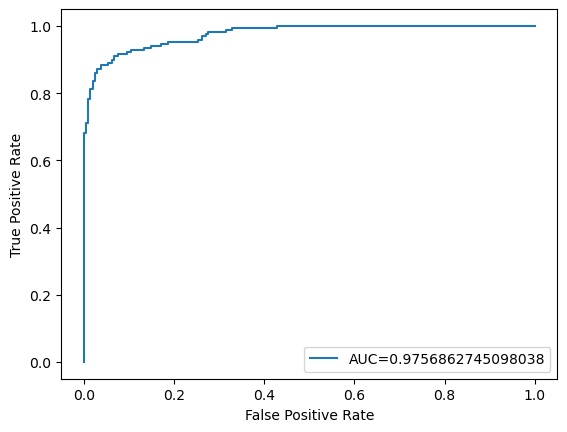

In [35]:
from sklearn import metrics

y_pred_proba = clf.predict_proba(df_train_LDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']])[::,1]
fpr, tpr, _ = metrics.roc_curve(df_train_LDA_robust.loc[:,'Y'],  y_pred_proba)

auc = metrics.roc_auc_score(df_train_LDA_robust.loc[:,'Y'], y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("LDA_ROC_filled.pdf")
plt.show()

0.7478070175438596


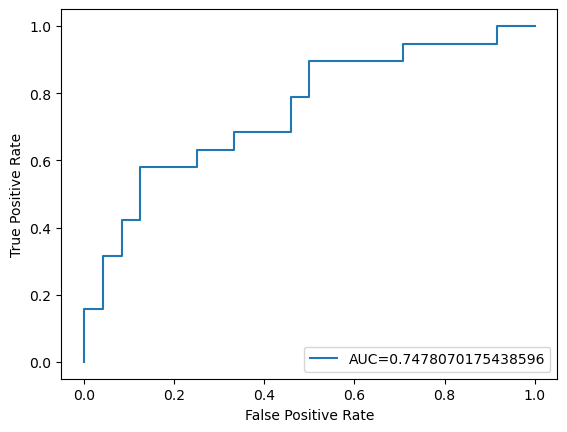

In [36]:
y_pred_proba = clf.predict_proba(df_test_LDA_robust.loc[:,['dist_l4','dist_l64','dist_l128']])[::,1]
fpr, tpr, _ = metrics.roc_curve(df_test_LDA_robust.loc[:,'Y'],  y_pred_proba)

auc = metrics.roc_auc_score(df_test_LDA_robust.loc[:,'Y'], y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig("LDA_ROC_prediction_filled.pdf")
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
vec_pre = clf.predict(df_train_LDA_robust.loc[df_train_LDA_robust['dsource'].isin(["train_id","train_ood"]),['dist_l4','dist_l64','dist_l128']])
confusion_matrix(df_train_LDA_robust.loc[df_train_LDA_robust['dsource'].isin(["train_id","train_ood"]),'Y'], vec_pre)

array([[202,   8],
       [ 22, 148]], dtype=int64)

In [38]:
from sklearn.metrics import confusion_matrix
vec_pre = clf.predict(df_test_LDA_robust.loc[df_test_LDA_robust['dsource'].isin(["test_id","test_ood"]),['dist_l4','dist_l64','dist_l128']])
confusion_matrix(df_test_LDA_robust.loc[df_test_LDA_robust['dsource'].isin(["test_id","test_ood"]),'Y'], vec_pre)

array([[ 5, 19],
       [ 1, 18]], dtype=int64)

## density plots

C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\2494602458.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]
C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\2494602458.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]
C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\2494602458.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]


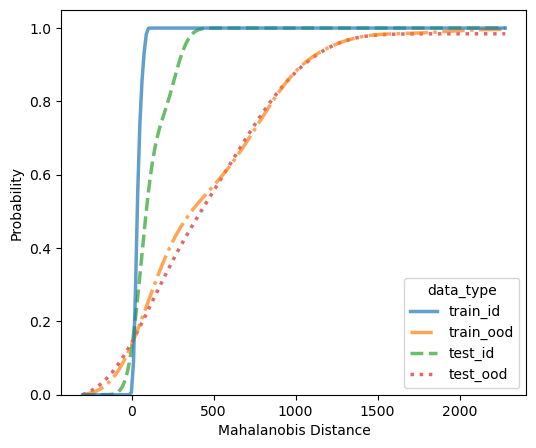

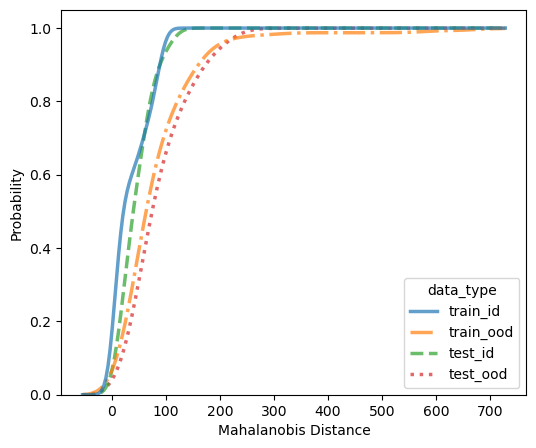

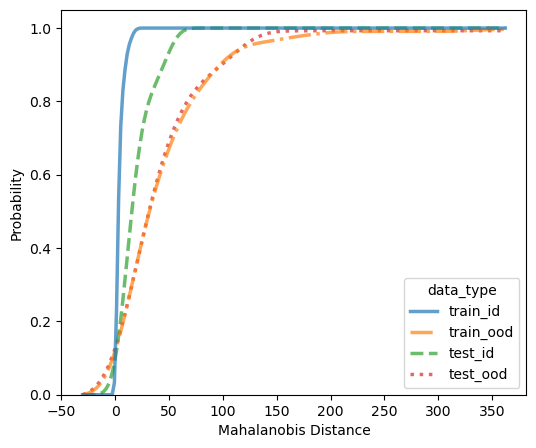

In [39]:
import seaborn as sns
df_QDA_robust = pd.concat([df_train_QDA_robust,df_test_QDA_robust])
df_QDA_robust = df_QDA_robust.rename({"dsource":"data_type"}, axis="columns")
fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_QDA_robust, x='dist_l128', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("QDA_fill_cdf_128.pdf")

fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_QDA_robust, x='dist_l64', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("QDA_fill_cdf_64.pdf")

fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_QDA_robust, x='dist_l4', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("QDA_fill_cdf_8.pdf")

C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\1777467801.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]
C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\1777467801.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]
C:\Users\tgh11\AppData\Local\Temp\ipykernel_29328\1777467801.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = p.legend_.legendHandles[::-1]


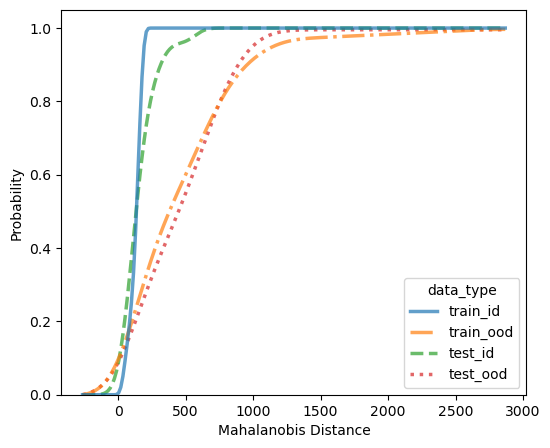

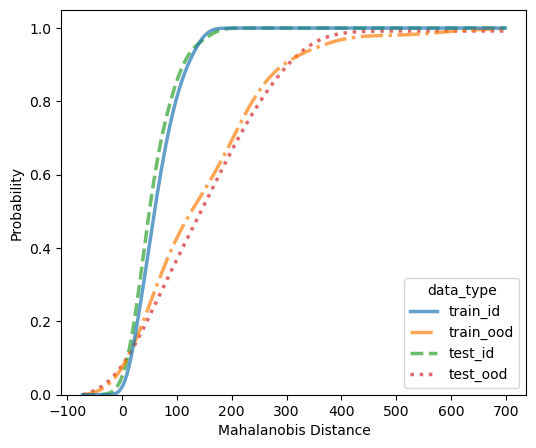

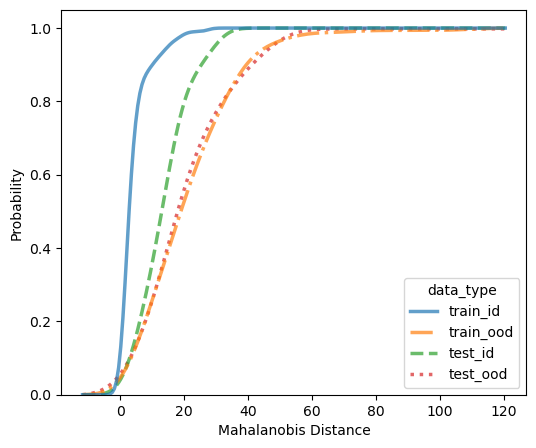

In [40]:
import seaborn as sns
df_LDA_robust = pd.concat([df_train_LDA_robust,df_test_LDA_robust])
df_LDA_robust = df_LDA_robust.rename({"dsource":"data_type"}, axis="columns")
fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_LDA_robust, x='dist_l128', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("LDA_fill_cdf_128.pdf")

fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_LDA_robust, x='dist_l64', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("LDA_fill_cdf_64.pdf")

fig = plt.figure(figsize=(6, 5))
p = sns.kdeplot(data=df_LDA_robust, x='dist_l4', hue='data_type',
    cumulative=True, common_norm=False, common_grid=True, alpha=0.7,
    linewidth = 2.5)
lss = [':', '--', '-.', '-']
handles = p.legend_.legendHandles[::-1]
for line, ls, handle in zip(p.lines, lss, handles):
    line.set_linestyle(ls)
    handle.set_ls(ls)
p.set(xlabel='Mahalanobis Distance', ylabel='Probability')
plt.savefig("LDA_fill_cdf_8.pdf")